In [1]:
import time
start_time = time.time()
import time
import matplotlib.pyplot as plt
import copy

In [3]:
def read_named_matrix_from_txt(file_path):
    with open(file_path, 'r') as f:
        lines = f.readlines()

    # Lấy tên các đỉnh từ dòng đầu tiên
    nodes = lines[0].strip().split()

    # Tạo ma trận từ các dòng còn lại
    matrix = []
    for line in lines[1:]:
        values = line.strip().split()[1:]  # Bỏ tên đỉnh ở đầu mỗi dòng
        matrix.append(list(map(int, values)))

    # Chuyển đổi ma trận thành đồ thị
    graph = {}
    n = len(nodes)
    for i in range(n):
        neighbors = []
        for j in range(n):
            neighbors.append((nodes[j], matrix[i][j]))
        graph[nodes[i]] = neighbors

    return graph

In [2]:
class Warshall:
    def __init__(self, graph, variables):
        self.graph = graph
        self.variables = variables
        self.n = len(variables)
        self.path_matrix = [[0] * self.n for _ in range(self.n)]
        self.create_path_matrix()

    def compute_shortest_paths(self):
        self.create_path_matrix()

    def get_shortest_path(self, start, end):
        city_index = {city: idx for idx, city in enumerate(self.variables)}
        return self.path_matrix[city_index[start]][city_index[end]]

    def create_path_matrix(self):
        city_index = {city: idx for idx, city in enumerate(self.variables)}

        for i in range(self.n):
            for j in range(self.n):
                self.path_matrix[i][j] = float('inf') if i != j else 0  # Khởi tạo khoảng cách ban đầu

        for city, neighbors in self.graph.items():
            for neighbor, weight in neighbors:
                self.path_matrix[city_index[city]][city_index[neighbor]] = weight

        for k in range(self.n):
            for i in range(self.n):
                for j in range(self.n):
                    self.path_matrix[i][j] = min(
                        self.path_matrix[i][j],
                        self.path_matrix[i][k] + self.path_matrix[k][j]
                    )

    def is_reachable(self, from_city, to_city):
        city_index = {city: idx for idx, city in enumerate(self.variables)}
        return self.path_matrix[city_index[from_city]][city_index[to_city]] != float('inf')

In [4]:
class CSPproblem:
    def __init__(self, variables, domains, graph, start, algorithm_choice='base'):
        self.variables = variables
        self.n = len(variables)
        self.domains = domains
        self.graph = graph
        self.start = start
        self.assignments = {}
        self.algorithm_choice = algorithm_choice
        self.min_cost = None
        self.min_path = []
        self.memo = {}

    def get_neighbors_degree(self, city, path):
        # Lấy danh sách neighbors và sắp xếp dựa trên Degree Heuristic
        neighbors = self.graph.get(city, [])
        # Lưu ý là bạn đang sắp xếp theo degree (số neighbors), không phải chi phí

        degree_order = sorted(neighbors, key=self.priority, reverse=True)  # Ưu tiên số lượng ràng buộc cao nhất
        return degree_order

    def priority(self, neighbor):
        """Tính độ ưu tiên (degree) của thành phố."""
        city = neighbor[0]
        return self.constraint_degree(city)

    def constraint_degree(self, city):
        """Tính số lượng ràng buộc (degree) của một thành phố."""
        return len(self.graph.get(city, []))

    def is_goal(self, current_city, path):
        return len(path) == self.n + 1 and current_city == self.start

    def is_consistent_constraint(self, city, path):
        return city not in path

    def get_neighbors(self, city):
        return self.graph.get(city, [])

    def assign(self, city, path):
        path.append(city)

    def unassign(self, city, path):
        path.pop()

    def forward_check(self, current_city, neighbor, path):
        remaining_domains = self.domains.copy()
        for city in self.variables:
            if city not in path and city != neighbor:
                for n, _ in self.get_neighbors(city):
                    if n == neighbor and n in remaining_domains[city]:
                        remaining_domains[city].remove(n)
                        # Nếu miền của biến nào rỗng, trả về False
                        if not remaining_domains[city]:
                            return False, remaining_domains
        return True, remaining_domains

    def revise(self, xi, xj):
        revised = False
        for x in self.domains[xi][:]:
            if not any(self.is_consistent_constraint(x, y) for y in self.domains[xj]):
                self.domains[xi].remove(x)
                revised = True
        return revised

    def apply_ac3(self):
        queue = [(xi, xj) for xi in self.domains for xj in self.domains if xi != xj]
        while queue:
            xi, xj = queue.pop(0)
            if self.revise(xi, xj):
                if not self.domains[xi]:
                    return False
                for xk in self.variables:
                    if xk != xi and xk != xj:
                        queue.append((xk, xi))
        return True

    def select_variable_highest_degree(self, path):
        """Chọn biến có số lượng ràng buộc (degree) lớn nhất."""
        max_degree = -1
        selected_variable = None
        for variable in self.variables:
            if variable not in path:
                degree = len([neighbor for neighbor, _ in self.get_neighbors(variable) if neighbor not in path])
                if degree > max_degree:
                    max_degree = degree
                    selected_variable = variable
        return selected_variable

    def minimum_remaining_values(self, path):
        min_remaining = float('inf')
        selected_variable = None
        for variable in self.variables:
            if variable not in path:
                remaining_values = len(self.domains[variable])
                if remaining_values < min_remaining:
                    min_remaining = remaining_values
                    selected_variable = variable
        return selected_variable

# **THÍ NGHIỆM BACKTRACKING + WARSHALL**

In [10]:
class BacktrackingWarshall:
    def __init__(self, graph, variables):
        self.warshall = Warshall(graph, variables)  # Tham chiếu đến lớp Warshall
        self.min_cost = float('inf')
        self.min_path = []
        self.steps = []  # Lưu tổng chi phí tại mỗi bước
        self.backtrack_count = 0  # Số lần thực hiện quay lui

    def backtrack(self, path, current_cost):
        self.steps.append((self.backtrack_count, current_cost))
        self.backtrack_count += 1
        if len(path) == len(self.warshall.variables):
            start_city = path[0]
            last_city = path[-1]
            total_cost = current_cost + self.warshall.get_shortest_path(last_city, start_city)
            if total_cost < self.min_cost:
                self.min_cost = total_cost
                self.min_path = path + [start_city]
            return

        # Lấy thành phố hiện tại
        current_city = path[-1]

        # Duyệt qua tất cả các thành phố còn lại
        for next_city in self.warshall.variables:
            if next_city not in path:
                cost_to_next = self.warshall.get_shortest_path(current_city, next_city)

                # Chỉ tiếp tục nếu chi phí hiện tại chưa vượt quá chi phí tốt nhất
                if current_cost + cost_to_next < self.min_cost:
                    # Gán giá trị (thêm thành phố vào đường đi)
                    path.append(next_city)
                    self.backtrack(path, current_cost + cost_to_next)
                    # Hủy gán giá trị (xóa thành phố khỏi đường đi)
                    path.pop()

    def solve(self, start_city):
        self.min_cost = float('inf')
        self.min_path = []
        self.backtrack([start_city], 0)
        return self.min_path, self.min_cost, self.steps, self.backtrack_count

### Thí nghiệm 1: Đồ thị 4x4

In [34]:
file_path = "matrix-4.txt"
graph = read_named_matrix_from_txt(file_path)
print(graph)

{'A': [('A', 0), ('B', 85), ('C', 26), ('D', 46)], 'B': [('A', 85), ('B', 0), ('C', 77), ('D', 97)], 'C': [('A', 26), ('B', 77), ('C', 0), ('D', 26)], 'D': [('A', 46), ('B', 97), ('C', 26), ('D', 0)]}


In [35]:
variables = list(graph.keys())
start = "A"
domains = {city: [neighbor[0] for neighbor in neighbors if neighbor[0] != city] for city, neighbors in graph.items()}

In [36]:
print("Warshall")
solver = BacktrackingWarshall(graph, variables)
start_time = time.time()
path, cost, steps, backtrack_counts = solver.solve(start)
end_time = time.time()
print(f"Execution Time: {end_time - start_time} seconds")
print("CSP Minimum Path:", path)
print("CSP Minimum Cost:", cost)
print("CSP Num of Step:", backtrack_counts)

Warshall
Execution Time: 0.0002110004425048828 seconds
CSP Minimum Path: ['A', 'B', 'C', 'D', 'A']
CSP Minimum Cost: 234
CSP Num of Step: 16


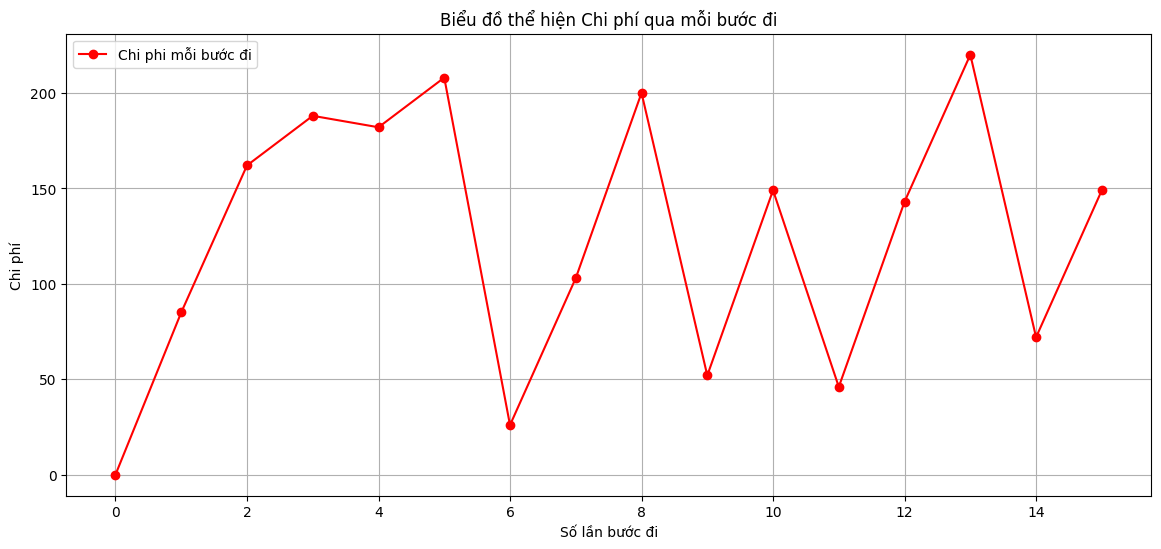

In [38]:
backtrack_counts = [step[0] for step in steps]
total_costs = [step[1] for step in steps]

plt.figure(figsize=(14, 6))

# Vẽ số lần backtrack
plt.plot(backtrack_counts, total_costs, label="Chi phi mỗi bước đi", color='red', marker='o')
plt.title("Biểu đồ thể hiện Chi phí qua mỗi bước đi")
plt.ylabel("Chi phí")
plt.xlabel("Số lần bước đi")
plt.legend()
plt.grid(True)
plt.show()

### Thí nghiệm 2: Đồ thị 8x8

In [40]:
file_path = "matrix-8.txt"
graph = read_named_matrix_from_txt(file_path)
print(graph)

{'A': [('A', 0), ('B', 85), ('C', 26), ('D', 13), ('E', 23), ('F', 36), ('G', 58), ('H', 19)], 'B': [('A', 85), ('B', 0), ('C', 77), ('D', 97), ('E', 10), ('F', 60), ('G', 7), ('H', 12)], 'C': [('A', 26), ('B', 77), ('C', 0), ('D', 26), ('E', 8), ('F', 10), ('G', 72), ('H', 42)], 'D': [('A', 13), ('B', 97), ('C', 26), ('D', 0), ('E', 70), ('F', 5), ('G', 24), ('H', 55)], 'E': [('A', 23), ('B', 10), ('C', 8), ('D', 70), ('E', 0), ('F', 85), ('G', 40), ('H', 23)], 'F': [('A', 36), ('B', 60), ('C', 10), ('D', 5), ('E', 85), ('F', 0), ('G', 30), ('H', 40)], 'G': [('A', 58), ('B', 7), ('C', 72), ('D', 24), ('E', 40), ('F', 30), ('G', 0), ('H', 90)], 'H': [('A', 19), ('B', 12), ('C', 42), ('D', 55), ('E', 23), ('F', 40), ('G', 90), ('H', 0)]}


In [41]:
variables = list(graph.keys())
start = "A"
domains = {city: [neighbor[0] for neighbor in neighbors if neighbor[0] != city] for city, neighbors in graph.items()}

In [42]:
print("Warshall")
solver = BacktrackingWarshall(graph, variables)
start_time = time.time()
path, cost, steps, backtrack_counts = solver.solve(start)
end_time = time.time()
print(f"Execution Time: {end_time - start_time} seconds")
print("CSP Minimum Path:", path)
print("CSP Minimum Cost:", cost)
print("CSP Num of Step:", backtrack_counts)

Warshall
Execution Time: 0.017035722732543945 seconds
CSP Minimum Path: ['A', 'D', 'F', 'C', 'E', 'B', 'G', 'H', 'A']
CSP Minimum Cost: 91
CSP Num of Step: 3036


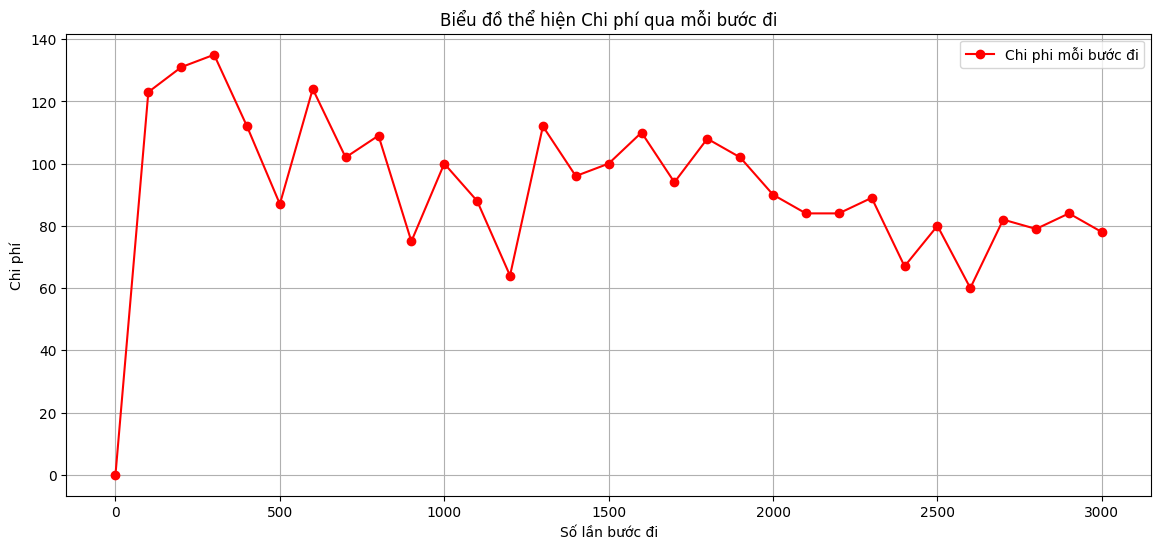

In [43]:
backtrack_counts = [step[0] for step in steps]
total_costs = [step[1] for step in steps]

sample_rate = 100  # Điều chỉnh mật độ
sampled_backtrack_counts = backtrack_counts[::sample_rate]
sampled_total_costs = total_costs[::sample_rate]

plt.figure(figsize=(14, 6))

# Vẽ số lần backtrack
plt.plot(sampled_backtrack_counts, sampled_total_costs, label="Chi phi mỗi bước đi", color='red', marker='o')
plt.title("Biểu đồ thể hiện Chi phí qua mỗi bước đi")
plt.ylabel("Chi phí")
plt.xlabel("Số lần bước đi")
plt.legend()
plt.grid(True)
plt.show()

### Thí nghiệm 3: Đồ thị 14 đỉnh không đầy đủ

In [47]:
graph = {
        'Tây Ninh': [('Đồng Nai', 85), ('Sài Gòn', 26), ('Bến Tre', 40)],
        'Đồng Nai': [('Sài Gòn', 737), ('Đà Nẵng', 83), ('Tây Ninh', 85)],
        'Sài Gòn': [('Đà Nẵng', 80), ('Tây Ninh', 26), ('Bến Tre', 120), ('Đồng Nai', 77)],
        'Bến Tre': [('Kiên Giang', 96), ('Tây Ninh', 40), ('Cửu Long', 83), ('Sài Gòn', 120)],
        'Cửu Long': [('Đà Nẵng', 140), ('Bến Tre', 83), ('Hà Nội', 49), ('Biên Hòa', 25)],
        'Đà Nẵng': [('Cửu Long', 140), ('Huế', 77), ('Đồng Nai', 83), ('Sài Gòn', 80)],
        'Kiên Giang': [('Bến Tre', 96), ('Biên Hòa', 73)],
        'Huế': [('Đà Nẵng', 77), ('Thái Bình', 93), ('Hà Nội', 78)],
        'Hà Nội': [('Cửu Long', 49), ('Huế', 78), ('Sơn La', 200), ('Hà Tĩnh', 71)],
        'Thái Bình': [('Sơn La', 280), ('Huế', 93)],
        'Sơn La': [('Hà Nội', 200), ('Thái Bình', 280), ('Hải Phòng', 77)],
        'Hải Phòng': [('Sơn La', 77), ('Hà Tĩnh', 50)],
        'Hà Tĩnh': [('Hải Phòng', 50), ('Hà Nội', 71), ('Biên Hòa', 30)],
        'Biên Hòa': [('Hà Tĩnh', 30), ('Cửu Long', 25), ('Kiên Giang', 73)]
        }

In [48]:
variables = list(graph.keys())
start = "Sài Gòn"
domains = {city: [neighbor[0] for neighbor in neighbors if neighbor[0] != city] for city, neighbors in graph.items()}

In [49]:
print("Warshall")
solver = BacktrackingWarshall(graph, variables)
start_time = time.time()
path, cost, steps, backtrack_counts = solver.solve(start)
end_time = time.time()
print(f"Execution Time: {end_time - start_time} seconds")
print("CSP Minimum Path:", path)
print("CSP Minimum Cost:", cost)
print("CSP Num of Step:", backtrack_counts)

Warshall
Execution Time: 432.4669260978699 seconds
CSP Minimum Path: ['Sài Gòn', 'Đồng Nai', 'Đà Nẵng', 'Huế', 'Thái Bình', 'Sơn La', 'Hải Phòng', 'Hà Tĩnh', 'Hà Nội', 'Cửu Long', 'Biên Hòa', 'Kiên Giang', 'Bến Tre', 'Tây Ninh', 'Sài Gòn']
CSP Minimum Cost: 1117
CSP Num of Step: 35014677


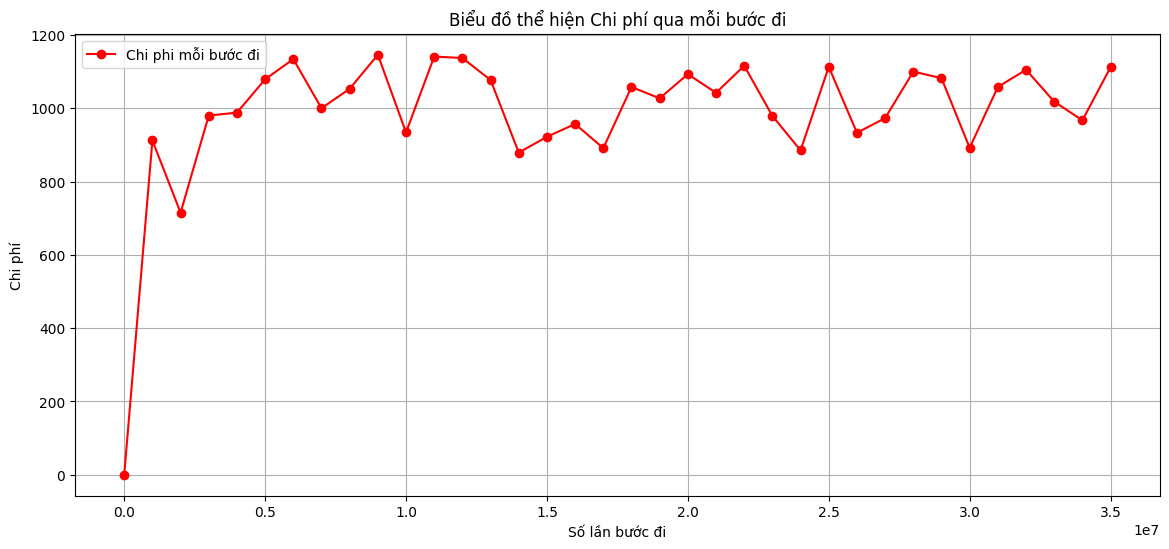

In [53]:
backtrack_counts = [step[0] for step in steps]
total_costs = [step[1] for step in steps]

sample_rate = 1000000  # Điều chỉnh mật độ
sampled_backtrack_counts = backtrack_counts[::sample_rate]
sampled_total_costs = total_costs[::sample_rate]

plt.figure(figsize=(14, 6))

# Vẽ số lần backtrack
plt.plot(sampled_backtrack_counts, sampled_total_costs, label="Chi phi mỗi bước đi", color='red', marker='o')
plt.title("Biểu đồ thể hiện Chi phí qua mỗi bước đi")
plt.ylabel("Chi phí")
plt.xlabel("Số lần bước đi")
plt.legend()
plt.grid(True)
plt.show()

# **THÍ NGHIỆM BACKTRACKING + AC3**

In [54]:
class Backtracking_ac3:
    def __init__(self, variables, domains, graph, start, algorithm_choice):
        self.problem = CSPproblem(variables, domains, graph, start, algorithm_choice)
        self.steps = []  # Lưu tổng chi phí tại mỗi bước
        self.backtrack_count = 0  # Số lần thực hiện quay lui

    def backtrack(self, path, current_cost):
        self.steps.append((self.backtrack_count, current_cost))
        self.backtrack_count += 1
        if len(path) == len(self.problem.variables):
            start_city = path[0]
            last_city = path[-1]

            # Thêm chi phí quay về thành phố ban đầu
            for neighbor, cost in self.problem.get_neighbors(last_city):
                if neighbor == start_city:
                    total_cost = current_cost + cost
                    if total_cost < self.problem.min_cost:
                        self.problem.min_cost = total_cost
                        self.problem.min_path = path + [start_city]
                    return

        # Gán giá trị cho các biến còn lại
        current_city = path[-1]
        for neighbor, cost in self.problem.get_neighbors(current_city):
            if self.problem.is_consistent_constraint(neighbor, path):
                original_domains = copy.deepcopy(self.problem.domains)
                # Áp dụng AC3
                if self.problem.apply_ac3():
                    # Gán giá trị
                    path.append(neighbor)
                    self.backtrack(path, current_cost + cost)
                    # Hủy gán giá trị
                    path.pop()
                # Khôi phục miền giá trị sau khi quay lui
                self.problem.domains = original_domains

    def solve(self, start_city):
        if not self.problem.apply_ac3():
            print("AC3 thất bại. Không thể giải bài toán.")
            return None, None
        self.problem.min_cost = float('inf')
        self.problem.min_path = []
        self.backtrack([start_city], 0)
        return self.problem.min_path, self.problem.min_cost, self.steps, self.backtrack_count

### Thí nghiệm 1: Đồ thị 4x4

In [55]:
file_path = "matrix-4.txt"
graph = read_named_matrix_from_txt(file_path)
print(graph)

{'A': [('A', 0), ('B', 85), ('C', 26), ('D', 46)], 'B': [('A', 85), ('B', 0), ('C', 77), ('D', 97)], 'C': [('A', 26), ('B', 77), ('C', 0), ('D', 26)], 'D': [('A', 46), ('B', 97), ('C', 26), ('D', 0)]}


In [51]:
variables = list(graph.keys())
start = "A"
domains = {city: [neighbor[0] for neighbor in neighbors if neighbor[0] != city] for city, neighbors in graph.items()}

In [58]:
print("AC3")
solver = Backtracking_ac3(variables, domains, graph, start, 'ac3')
start_time = time.time()
path, cost, steps, backtrack_counts = solver.solve(start)
end_time = time.time()
print(f"Execution Time: {end_time - start_time} seconds")
print("CSP Minimum Path:", path)
print("CSP Minimum Cost:", cost)
print("CSP Num of Step:", backtrack_counts)

AC3
Execution Time: 0.003425121307373047 seconds
CSP Minimum Path: ['A', 'B', 'C', 'D', 'A']
CSP Minimum Cost: 234
CSP Num of Step: 16


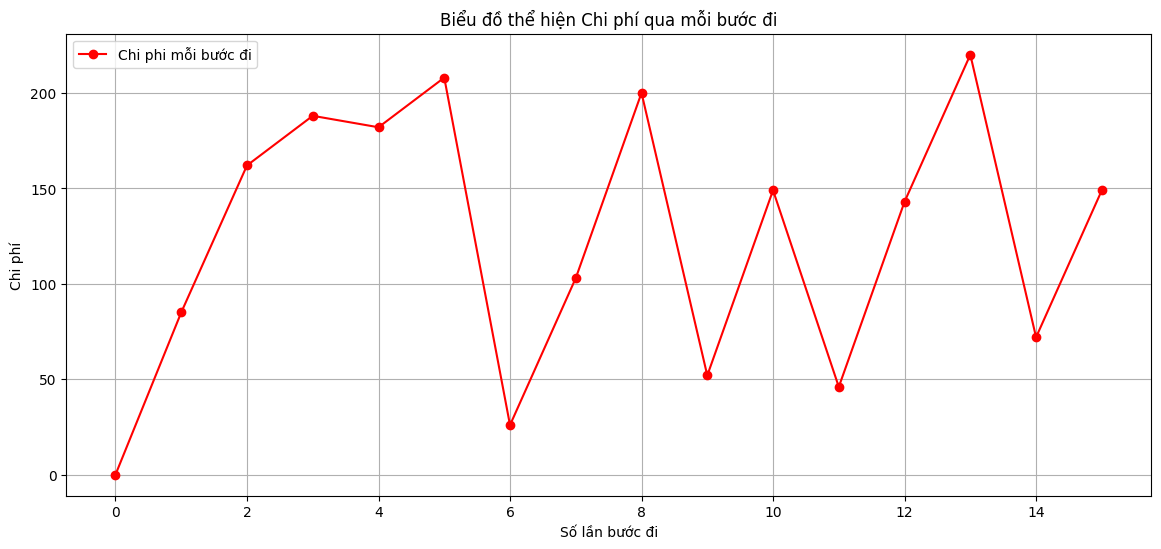

In [59]:
backtrack_counts = [step[0] for step in steps]
total_costs = [step[1] for step in steps]

plt.figure(figsize=(14, 6))

# Vẽ số lần backtrack
plt.plot(backtrack_counts, total_costs, label="Chi phi mỗi bước đi", color='red', marker='o')
plt.title("Biểu đồ thể hiện Chi phí qua mỗi bước đi")
plt.ylabel("Chi phí")
plt.xlabel("Số lần bước đi")
plt.legend()
plt.grid(True)
plt.show()

### Thí nghiệm 2: Đồ thị 8x8

In [60]:
file_path = "matrix-8.txt"
graph = read_named_matrix_from_txt(file_path)
print(graph)

{'A': [('A', 0), ('B', 85), ('C', 26), ('D', 13), ('E', 23), ('F', 36), ('G', 58), ('H', 19)], 'B': [('A', 85), ('B', 0), ('C', 77), ('D', 97), ('E', 10), ('F', 60), ('G', 7), ('H', 12)], 'C': [('A', 26), ('B', 77), ('C', 0), ('D', 26), ('E', 8), ('F', 10), ('G', 72), ('H', 42)], 'D': [('A', 13), ('B', 97), ('C', 26), ('D', 0), ('E', 70), ('F', 5), ('G', 24), ('H', 55)], 'E': [('A', 23), ('B', 10), ('C', 8), ('D', 70), ('E', 0), ('F', 85), ('G', 40), ('H', 23)], 'F': [('A', 36), ('B', 60), ('C', 10), ('D', 5), ('E', 85), ('F', 0), ('G', 30), ('H', 40)], 'G': [('A', 58), ('B', 7), ('C', 72), ('D', 24), ('E', 40), ('F', 30), ('G', 0), ('H', 90)], 'H': [('A', 19), ('B', 12), ('C', 42), ('D', 55), ('E', 23), ('F', 40), ('G', 90), ('H', 0)]}


In [61]:
variables = list(graph.keys())
start = "A"
domains = {city: [neighbor[0] for neighbor in neighbors if neighbor[0] != city] for city, neighbors in graph.items()}

In [62]:
print("AC3")
solver = Backtracking_ac3(variables, domains, graph, start, 'ac3')
start_time = time.time()
path, cost, steps, backtrack_counts = solver.solve(start)
end_time = time.time()
print(f"Execution Time: {end_time - start_time} seconds")
print("CSP Minimum Path:", path)
print("CSP Minimum Cost:", cost)
print("CSP Num of Step:", backtrack_counts)

AC3
Execution Time: 5.290000915527344 seconds
CSP Minimum Path: ['A', 'E', 'C', 'F', 'D', 'G', 'B', 'H', 'A']
CSP Minimum Cost: 108
CSP Num of Step: 13700


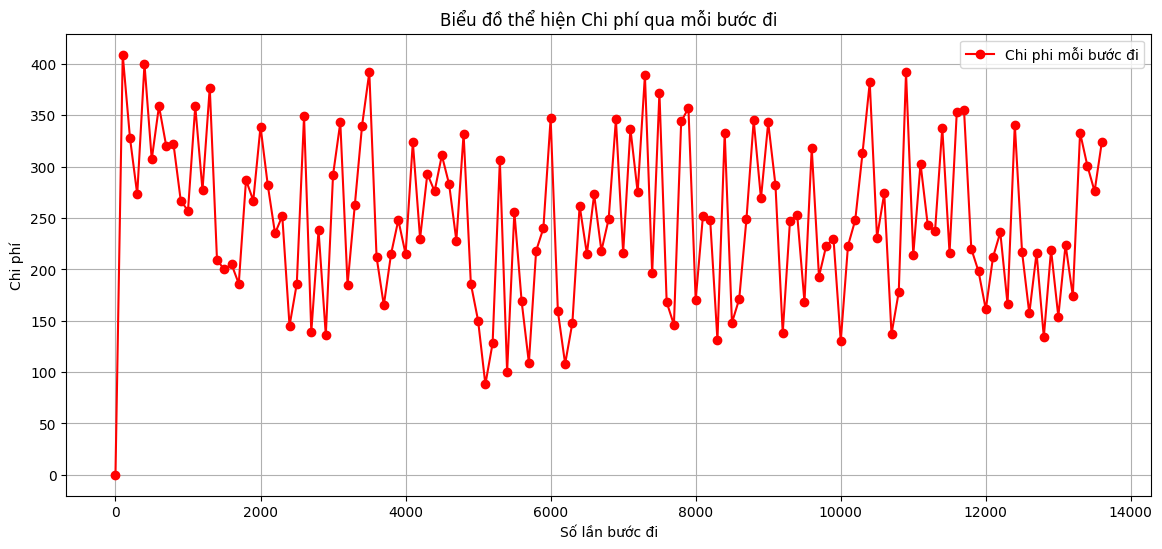

In [63]:
backtrack_counts = [step[0] for step in steps]
total_costs = [step[1] for step in steps]

sample_rate = 100  # Điều chỉnh mật độ
sampled_backtrack_counts = backtrack_counts[::sample_rate]
sampled_total_costs = total_costs[::sample_rate]

plt.figure(figsize=(14, 6))

# Vẽ số lần backtrack
plt.plot(sampled_backtrack_counts, sampled_total_costs, label="Chi phi mỗi bước đi", color='red', marker='o')
plt.title("Biểu đồ thể hiện Chi phí qua mỗi bước đi")
plt.ylabel("Chi phí")
plt.xlabel("Số lần bước đi")
plt.legend()
plt.grid(True)
plt.show()

### Thí nghiệm 3: Đồ thị 14 đỉnh không đầy đủ

In [64]:
graph = {
        'Tây Ninh': [('Đồng Nai', 85), ('Sài Gòn', 26), ('Bến Tre', 40)],
        'Đồng Nai': [('Sài Gòn', 737), ('Đà Nẵng', 83), ('Tây Ninh', 85)],
        'Sài Gòn': [('Đà Nẵng', 80), ('Tây Ninh', 26), ('Bến Tre', 120), ('Đồng Nai', 77)],
        'Bến Tre': [('Kiên Giang', 96), ('Tây Ninh', 40), ('Cửu Long', 83), ('Sài Gòn', 120)],
        'Cửu Long': [('Đà Nẵng', 140), ('Bến Tre', 83), ('Hà Nội', 49), ('Biên Hòa', 25)],
        'Đà Nẵng': [('Cửu Long', 140), ('Huế', 77), ('Đồng Nai', 83), ('Sài Gòn', 80)],
        'Kiên Giang': [('Bến Tre', 96), ('Biên Hòa', 73)],
        'Huế': [('Đà Nẵng', 77), ('Thái Bình', 93), ('Hà Nội', 78)],
        'Hà Nội': [('Cửu Long', 49), ('Huế', 78), ('Sơn La', 200), ('Hà Tĩnh', 71)],
        'Thái Bình': [('Sơn La', 280), ('Huế', 93)],
        'Sơn La': [('Hà Nội', 200), ('Thái Bình', 280), ('Hải Phòng', 77)],
        'Hải Phòng': [('Sơn La', 77), ('Hà Tĩnh', 50)],
        'Hà Tĩnh': [('Hải Phòng', 50), ('Hà Nội', 71), ('Biên Hòa', 30)],
        'Biên Hòa': [('Hà Tĩnh', 30), ('Cửu Long', 25), ('Kiên Giang', 73)]
        }

In [65]:
variables = list(graph.keys())
start = "Sài Gòn"
domains = {city: [neighbor[0] for neighbor in neighbors if neighbor[0] != city] for city, neighbors in graph.items()}

In [66]:
print("AC3")
solver = Backtracking_ac3(variables, domains, graph, start, 'ac3')
start_time = time.time()
path, cost, steps, backtrack_counts = solver.solve(start)
end_time = time.time()
print(f"Execution Time: {end_time - start_time} seconds")
print("CSP Minimum Path:", path)
print("CSP Minimum Cost:", cost)
print("CSP Num of Step:", backtrack_counts)

AC3
Execution Time: 0.8821637630462646 seconds
CSP Minimum Path: ['Sài Gòn', 'Đồng Nai', 'Đà Nẵng', 'Huế', 'Thái Bình', 'Sơn La', 'Hải Phòng', 'Hà Tĩnh', 'Hà Nội', 'Cửu Long', 'Biên Hòa', 'Kiên Giang', 'Bến Tre', 'Tây Ninh', 'Sài Gòn']
CSP Minimum Cost: 1117
CSP Num of Step: 1221


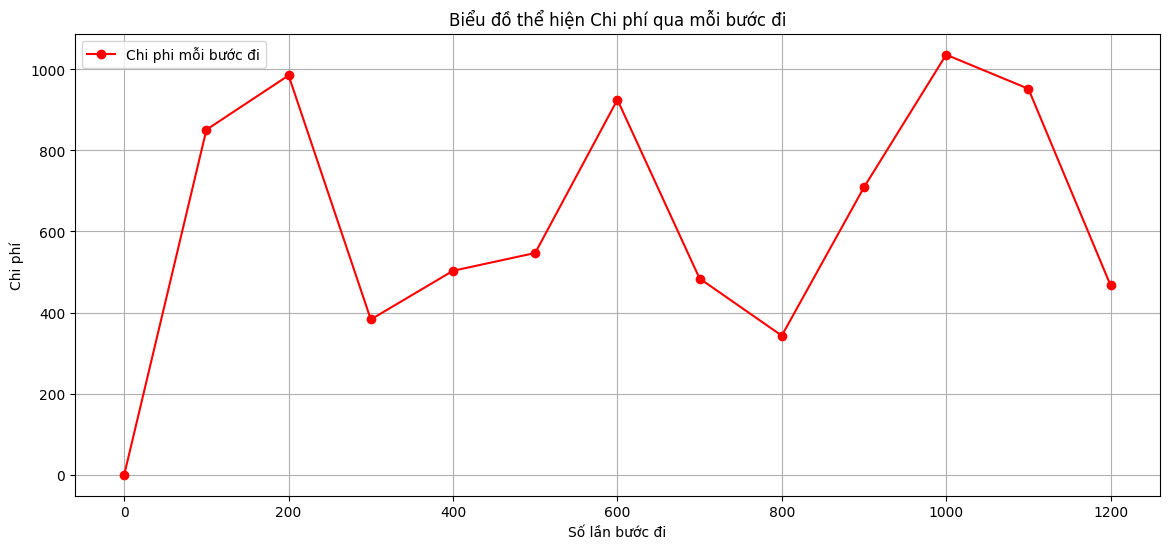

In [67]:
backtrack_counts = [step[0] for step in steps]
total_costs = [step[1] for step in steps]

sample_rate = 100  # Điều chỉnh mật độ
sampled_backtrack_counts = backtrack_counts[::sample_rate]
sampled_total_costs = total_costs[::sample_rate]

plt.figure(figsize=(14, 6))

# Vẽ số lần backtrack
plt.plot(sampled_backtrack_counts, sampled_total_costs, label="Chi phi mỗi bước đi", color='red', marker='o')
plt.title("Biểu đồ thể hiện Chi phí qua mỗi bước đi")
plt.ylabel("Chi phí")
plt.xlabel("Số lần bước đi")
plt.legend()
plt.grid(True)
plt.show()

# **THÍ NGHIỆM BACKTRACKING + FORWARD CHECKING**

In [86]:
class Backtracking_fc:
    def __init__(self, variables, domains, graph, start, algorithm_choice):
        self.problem = CSPproblem(variables, domains, graph, start, algorithm_choice)
        self.steps = []  # Lưu tổng chi phí tại mỗi bước
        self.backtrack_count = 0  # Số lần thực hiện quay lui

    def backtrack(self, current_city, path_length, path):
        self.steps.append((self.backtrack_count, path_length))
        self.backtrack_count += 1
        if self.problem.is_goal(current_city, path):
            if self.problem.min_cost is None or path_length < self.problem.min_cost:
                self.problem.min_cost = path_length
                self.problem.min_path = path.copy()
            return

        for (neighbor, distance) in self.problem.get_neighbors(current_city):
            if self.problem.is_consistent_constraint(neighbor, path):
                is_valid, remaining_domains = self.problem.forward_check(current_city, neighbor, path)
                if is_valid:
                    self.problem.assign(neighbor,path)
                    original_domains = self.problem.domains
                    self.problem.domains = remaining_domains
                    self.backtrack(neighbor,path_length + distance, path)
                    self.problem.domains = original_domains
                    self.problem.unassign(neighbor,path)

        if len(path) == self.problem.n:
            for (neighbor, distance) in self.problem.get_neighbors(current_city):
                if neighbor == self.problem.start:
                    self.problem.assign(neighbor, path)
                    self.backtrack(neighbor, path_length + distance, path)
                    self.problem.unassign(neighbor,path)

    def solve(self):
        start_city = self.problem.start
        self.problem.assign(start_city, [start_city])
        self.backtrack(start_city, 0, [start_city])
        return self.problem.min_path, self.problem.min_cost, self.steps, self.backtrack_count

### Thí nghiệm 1: Đồ thị 4x4

In [103]:
file_path = "matrix-4.txt"
graph = read_named_matrix_from_txt(file_path)
print(graph)

{'A': [('A', 0), ('B', 85), ('C', 26), ('D', 46)], 'B': [('A', 85), ('B', 0), ('C', 77), ('D', 97)], 'C': [('A', 26), ('B', 77), ('C', 0), ('D', 26)], 'D': [('A', 46), ('B', 97), ('C', 26), ('D', 0)]}


In [104]:
variables = list(graph.keys())
start = 'A'
domains = {city: [neighbor[0] for neighbor in neighbors if neighbor[0] != city] for city, neighbors in graph.items()}

In [105]:
print("Forward Check")
solver = Backtracking_fc(variables, domains, graph, start, 'fc')
start_time = time.time()
path, cost, steps, backtrack_counts = solver.solve()
end_time = time.time()
print(f"Execution Time: {end_time - start_time} seconds")
print("CSP Minimum Path:", path)
print("CSP Minimum Cost:", cost)
print("CSP Num of Step:", backtrack_counts)

Forward Check
Execution Time: 0.000354766845703125 seconds
CSP Minimum Path: ['A', 'B', 'C', 'D', 'A']
CSP Minimum Cost: 234
CSP Num of Step: 22


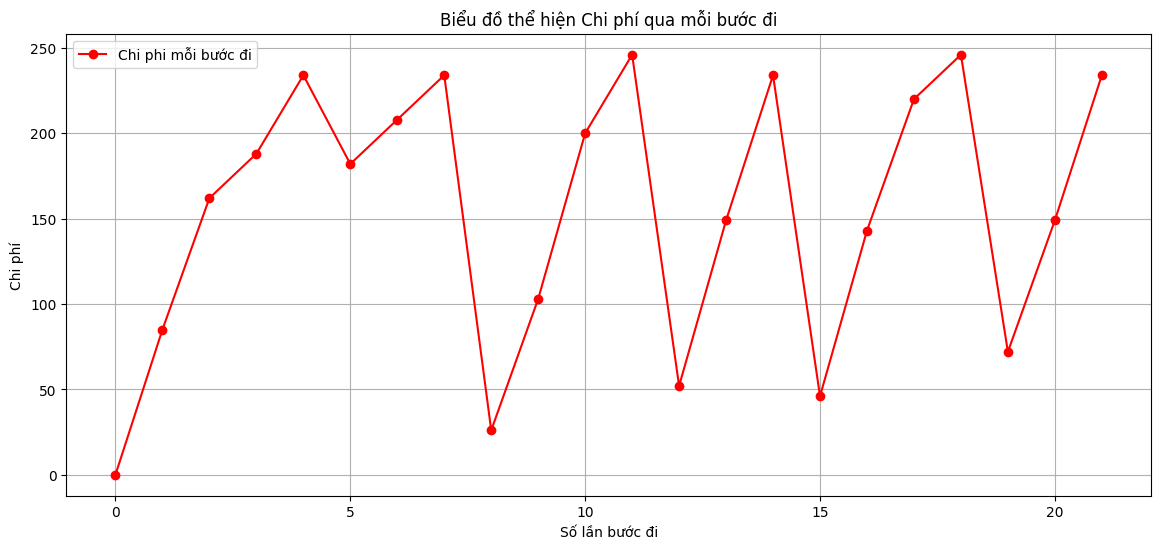

In [106]:
backtrack_counts = [step[0] for step in steps]
total_costs = [step[1] for step in steps]

plt.figure(figsize=(14, 6))

# Vẽ số lần backtrack
plt.plot(backtrack_counts, total_costs, label="Chi phi mỗi bước đi", color='red', marker='o')
plt.title("Biểu đồ thể hiện Chi phí qua mỗi bước đi")
plt.ylabel("Chi phí")
plt.xlabel("Số lần bước đi")
plt.legend()
plt.grid(True)
plt.show()

### Thí nghiệm 2: Đồ thị 8x8

In [107]:
file_path = "matrix-8.txt"
graph = read_named_matrix_from_txt(file_path)
print(graph)

{'A': [('A', 0), ('B', 85), ('C', 26), ('D', 13), ('E', 23), ('F', 36), ('G', 58), ('H', 19)], 'B': [('A', 85), ('B', 0), ('C', 77), ('D', 97), ('E', 10), ('F', 60), ('G', 7), ('H', 12)], 'C': [('A', 26), ('B', 77), ('C', 0), ('D', 26), ('E', 8), ('F', 10), ('G', 72), ('H', 42)], 'D': [('A', 13), ('B', 97), ('C', 26), ('D', 0), ('E', 70), ('F', 5), ('G', 24), ('H', 55)], 'E': [('A', 23), ('B', 10), ('C', 8), ('D', 70), ('E', 0), ('F', 85), ('G', 40), ('H', 23)], 'F': [('A', 36), ('B', 60), ('C', 10), ('D', 5), ('E', 85), ('F', 0), ('G', 30), ('H', 40)], 'G': [('A', 58), ('B', 7), ('C', 72), ('D', 24), ('E', 40), ('F', 30), ('G', 0), ('H', 90)], 'H': [('A', 19), ('B', 12), ('C', 42), ('D', 55), ('E', 23), ('F', 40), ('G', 90), ('H', 0)]}


In [108]:
variables = list(graph.keys())
start = 'A'
domains = {city: [neighbor[0] for neighbor in neighbors if neighbor[0] != city] for city, neighbors in graph.items()}

In [109]:
print("Forward Check")
solver = Backtracking_fc(variables, domains, graph, start, 'fc')
start_time = time.time()
path, cost, steps, backtrack_counts = solver.solve()
end_time = time.time()
print(f"Execution Time: {end_time - start_time} seconds")
print("CSP Minimum Path:", path)
print("CSP Minimum Cost:", cost)
print("CSP Num of Step:", backtrack_counts)

Forward Check
Execution Time: 0.09880185127258301 seconds
CSP Minimum Path: ['A', 'E', 'C', 'F', 'D', 'G', 'B', 'H', 'A']
CSP Minimum Cost: 108
CSP Num of Step: 18740


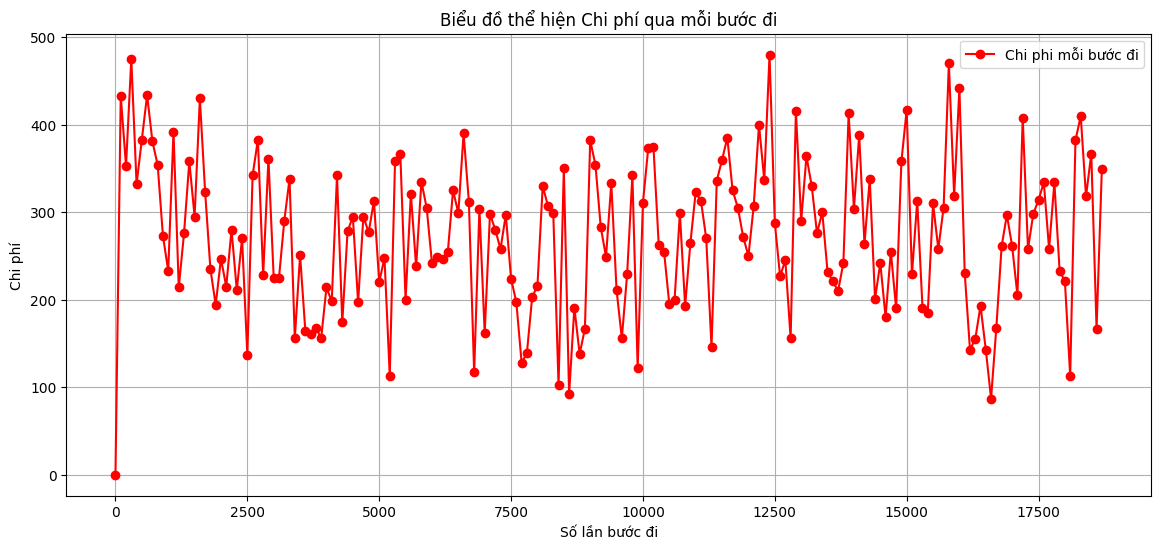

In [110]:
backtrack_counts = [step[0] for step in steps]
total_costs = [step[1] for step in steps]

sample_rate = 100  # Điều chỉnh mật độ
sampled_backtrack_counts = backtrack_counts[::sample_rate]
sampled_total_costs = total_costs[::sample_rate]

plt.figure(figsize=(14, 6))

# Vẽ số lần backtrack
plt.plot(sampled_backtrack_counts, sampled_total_costs, label="Chi phi mỗi bước đi", color='red', marker='o')
plt.title("Biểu đồ thể hiện Chi phí qua mỗi bước đi")
plt.ylabel("Chi phí")
plt.xlabel("Số lần bước đi")
plt.legend()
plt.grid(True)
plt.show()

### Thí nghiệm 3: Đồ thị 14 đỉnh không đầy đủ

In [73]:
graph = {
        'Tây Ninh': [('Đồng Nai', 85), ('Sài Gòn', 26), ('Bến Tre', 40)],
        'Đồng Nai': [('Sài Gòn', 737), ('Đà Nẵng', 83), ('Tây Ninh', 85)],
        'Sài Gòn': [('Đà Nẵng', 80), ('Tây Ninh', 26), ('Bến Tre', 120), ('Đồng Nai', 77)],
        'Bến Tre': [('Kiên Giang', 96), ('Tây Ninh', 40), ('Cửu Long', 83), ('Sài Gòn', 120)],
        'Cửu Long': [('Đà Nẵng', 140), ('Bến Tre', 83), ('Hà Nội', 49), ('Biên Hòa', 25)],
        'Đà Nẵng': [('Cửu Long', 140), ('Huế', 77), ('Đồng Nai', 83), ('Sài Gòn', 80)],
        'Kiên Giang': [('Bến Tre', 96), ('Biên Hòa', 73)],
        'Huế': [('Đà Nẵng', 77), ('Thái Bình', 93), ('Hà Nội', 78)],
        'Hà Nội': [('Cửu Long', 49), ('Huế', 78), ('Sơn La', 200), ('Hà Tĩnh', 71)],
        'Thái Bình': [('Sơn La', 280), ('Huế', 93)],
        'Sơn La': [('Hà Nội', 200), ('Thái Bình', 280), ('Hải Phòng', 77)],
        'Hải Phòng': [('Sơn La', 77), ('Hà Tĩnh', 50)],
        'Hà Tĩnh': [('Hải Phòng', 50), ('Hà Nội', 71), ('Biên Hòa', 30)],
        'Biên Hòa': [('Hà Tĩnh', 30), ('Cửu Long', 25), ('Kiên Giang', 73)]
        }

In [74]:
variables = list(graph.keys())
start = "Sài Gòn"
domains = {city: [neighbor[0] for neighbor in neighbors if neighbor[0] != city] for city, neighbors in graph.items()}

In [77]:
print("Forward Check")
solver = Backtracking_fc(variables, domains, graph, start, 'fc')
start_time = time.time()
path, cost, steps, backtrack_counts = solver.solve()
end_time = time.time()
print(f"Execution Time: {end_time - start_time} seconds")
print("CSP Minimum Path:", path)
print("CSP Minimum Cost:", cost)
print("CSP Num of Step:", backtrack_counts)

Forward Check
Execution Time: 0.009308815002441406 seconds
CSP Minimum Path: ['Sài Gòn', 'Đồng Nai', 'Đà Nẵng', 'Huế', 'Thái Bình', 'Sơn La', 'Hải Phòng', 'Hà Tĩnh', 'Hà Nội', 'Cửu Long', 'Biên Hòa', 'Kiên Giang', 'Bến Tre', 'Tây Ninh', 'Sài Gòn']
CSP Minimum Cost: 1117
CSP Num of Step: 1196


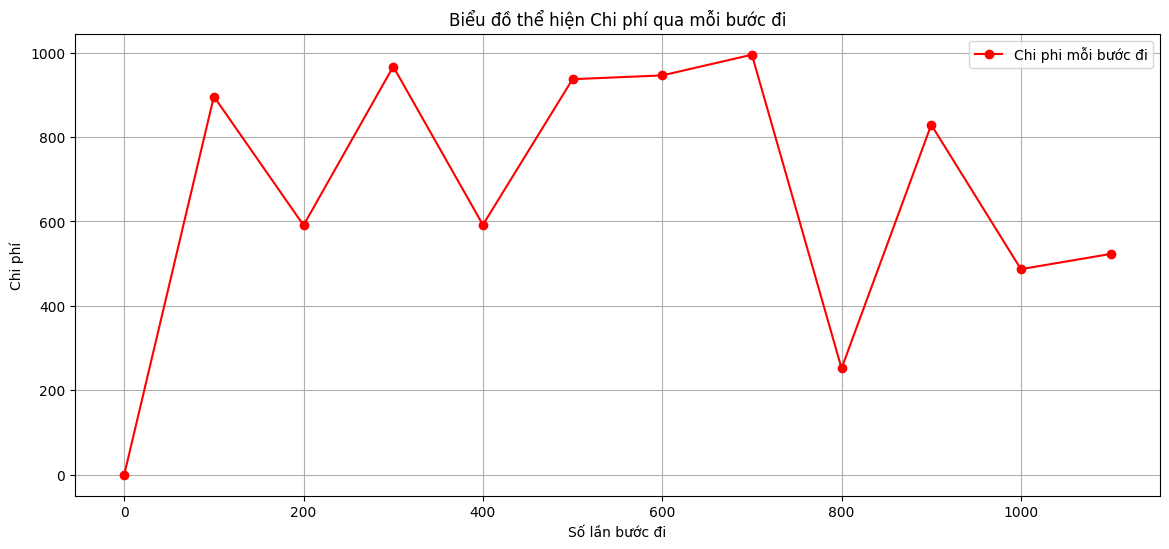

In [78]:
backtrack_counts = [step[0] for step in steps]
total_costs = [step[1] for step in steps]

sample_rate = 100  # Điều chỉnh mật độ
sampled_backtrack_counts = backtrack_counts[::sample_rate]
sampled_total_costs = total_costs[::sample_rate]

plt.figure(figsize=(14, 6))

# Vẽ số lần backtrack
plt.plot(sampled_backtrack_counts, sampled_total_costs, label="Chi phi mỗi bước đi", color='red', marker='o')
plt.title("Biểu đồ thể hiện Chi phí qua mỗi bước đi")
plt.ylabel("Chi phí")
plt.xlabel("Số lần bước đi")
plt.legend()
plt.grid(True)
plt.show()

# **THÍ NGHIỆM BACKTRACKING + VARIABLE WITH HIGHEST DEGREE**

In [95]:
class Backtracking_degree:
    def __init__(self, variables, domains, graph, start, algorithm_choice):
        self.problem = CSPproblem(variables, domains, graph, start, algorithm_choice)
        self.steps = []  # Lưu tổng chi phí tại mỗi bước
        self.backtrack_count = 0  # Số lần thực hiện quay lui

    def backtrack(self, current_city, path_length, path):
        self.steps.append((self.backtrack_count, path_length))
        self.backtrack_count += 1

        if self.problem.is_goal(current_city, path):
            if self.problem.min_cost is None or path_length < self.problem.min_cost:
                self.problem.min_cost = path_length
                self.problem.min_path = path.copy()
            return

        for (neighbor, distance) in self.problem.get_neighbors_degree(current_city, path):
            if self.problem.is_consistent_constraint(neighbor, path):
                self.problem.assign(neighbor, path)
                self.backtrack(neighbor, path_length + distance, path)
                self.problem.unassign(neighbor, path)

        if len(path) == self.problem.n:
            for (neighbor, distance) in self.problem.get_neighbors_degree(current_city, path):
                if neighbor == self.problem.start:
                    self.problem.assign(neighbor, path)
                    self.backtrack(neighbor, path_length + distance, path)
                    self.problem.unassign(neighbor,path)

    def solve(self):
        start_city = self.problem.start
        self.problem.assign(start_city, [start_city])
        self.backtrack(start_city, 0, [start_city])
        return self.problem.min_path, self.problem.min_cost, self.steps, self.backtrack_count

### Thí nghiệm 1: Đồ thị 4x4

In [119]:
file_path = "matrix-4.txt"
graph = read_named_matrix_from_txt(file_path)
print(graph)

{'A': [('A', 0), ('B', 85), ('C', 26), ('D', 46)], 'B': [('A', 85), ('B', 0), ('C', 77), ('D', 97)], 'C': [('A', 26), ('B', 77), ('C', 0), ('D', 26)], 'D': [('A', 46), ('B', 97), ('C', 26), ('D', 0)]}


In [120]:
variables = list(graph.keys())
start = 'A'
domains = {city: [neighbor[0] for neighbor in neighbors if neighbor[0] != city] for city, neighbors in graph.items()}

In [121]:
print("Degree")
solver = Backtracking_degree(variables, domains, graph, start, 'degree')
start_time = time.time()
path, cost, steps, backtrack_counts = solver.solve()
end_time = time.time()
print(f"Execution Time: {end_time - start_time} seconds")
print("CSP Minimum Path:", path)
print("CSP Minimum Cost:", cost)
print("CSP Num of Step:", backtrack_counts)

Degree
Execution Time: 0.0003008842468261719 seconds
CSP Minimum Path: ['A', 'B', 'C', 'D', 'A']
CSP Minimum Cost: 234
CSP Num of Step: 22


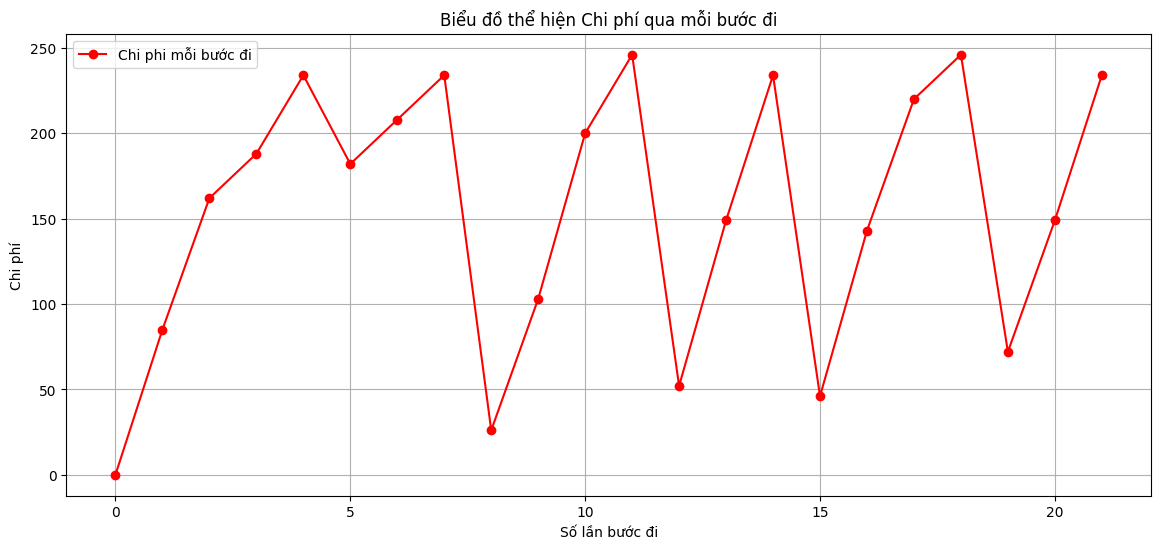

In [123]:
backtrack_counts = [step[0] for step in steps]
total_costs = [step[1] for step in steps]

plt.figure(figsize=(14, 6))

# Vẽ số lần backtrack
plt.plot(backtrack_counts, total_costs, label="Chi phi mỗi bước đi", color='red', marker='o')
plt.title("Biểu đồ thể hiện Chi phí qua mỗi bước đi")
plt.ylabel("Chi phí")
plt.xlabel("Số lần bước đi")
plt.legend()
plt.grid(True)
plt.show()

### Thí nghiệm 2: Đồ thị 8x8

In [124]:
file_path = "matrix-8.txt"
graph = read_named_matrix_from_txt(file_path)
print(graph)

{'A': [('A', 0), ('B', 85), ('C', 26), ('D', 13), ('E', 23), ('F', 36), ('G', 58), ('H', 19)], 'B': [('A', 85), ('B', 0), ('C', 77), ('D', 97), ('E', 10), ('F', 60), ('G', 7), ('H', 12)], 'C': [('A', 26), ('B', 77), ('C', 0), ('D', 26), ('E', 8), ('F', 10), ('G', 72), ('H', 42)], 'D': [('A', 13), ('B', 97), ('C', 26), ('D', 0), ('E', 70), ('F', 5), ('G', 24), ('H', 55)], 'E': [('A', 23), ('B', 10), ('C', 8), ('D', 70), ('E', 0), ('F', 85), ('G', 40), ('H', 23)], 'F': [('A', 36), ('B', 60), ('C', 10), ('D', 5), ('E', 85), ('F', 0), ('G', 30), ('H', 40)], 'G': [('A', 58), ('B', 7), ('C', 72), ('D', 24), ('E', 40), ('F', 30), ('G', 0), ('H', 90)], 'H': [('A', 19), ('B', 12), ('C', 42), ('D', 55), ('E', 23), ('F', 40), ('G', 90), ('H', 0)]}


In [125]:
variables = list(graph.keys())
start = 'A'
domains = {city: [neighbor[0] for neighbor in neighbors if neighbor[0] != city] for city, neighbors in graph.items()}

In [126]:
print("Degree")
solver = Backtracking_degree(variables, domains, graph, start, 'degree')
start_time = time.time()
path, cost, steps, backtrack_counts = solver.solve()
end_time = time.time()
print(f"Execution Time: {end_time - start_time} seconds")
print("CSP Minimum Path:", path)
print("CSP Minimum Cost:", cost)
print("CSP Num of Step:", backtrack_counts)

Degree
Execution Time: 0.13064813613891602 seconds
CSP Minimum Path: ['A', 'E', 'C', 'F', 'D', 'G', 'B', 'H', 'A']
CSP Minimum Cost: 108
CSP Num of Step: 18740


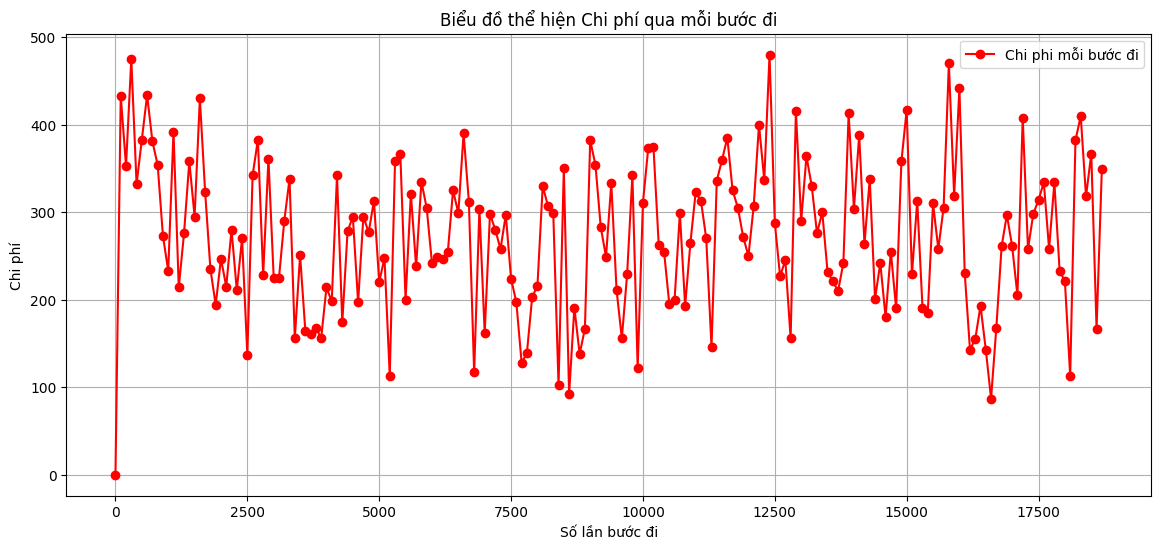

In [127]:
backtrack_counts = [step[0] for step in steps]
total_costs = [step[1] for step in steps]

sample_rate = 100  # Điều chỉnh mật độ
sampled_backtrack_counts = backtrack_counts[::sample_rate]
sampled_total_costs = total_costs[::sample_rate]

plt.figure(figsize=(14, 6))

# Vẽ số lần backtrack
plt.plot(sampled_backtrack_counts, sampled_total_costs, label="Chi phi mỗi bước đi", color='red', marker='o')
plt.title("Biểu đồ thể hiện Chi phí qua mỗi bước đi")
plt.ylabel("Chi phí")
plt.xlabel("Số lần bước đi")
plt.legend()
plt.grid(True)
plt.show()

### Thí nghiệm 3: Đồ thị 14 đỉnh không đầy đủ

In [92]:
graph = {
        'Tây Ninh': [('Đồng Nai', 85), ('Sài Gòn', 26), ('Bến Tre', 40)],
        'Đồng Nai': [('Sài Gòn', 737), ('Đà Nẵng', 83), ('Tây Ninh', 85)],
        'Sài Gòn': [('Đà Nẵng', 80), ('Tây Ninh', 26), ('Bến Tre', 120), ('Đồng Nai', 77)],
        'Bến Tre': [('Kiên Giang', 96), ('Tây Ninh', 40), ('Cửu Long', 83), ('Sài Gòn', 120)],
        'Cửu Long': [('Đà Nẵng', 140), ('Bến Tre', 83), ('Hà Nội', 49), ('Biên Hòa', 25)],
        'Đà Nẵng': [('Cửu Long', 140), ('Huế', 77), ('Đồng Nai', 83), ('Sài Gòn', 80)],
        'Kiên Giang': [('Bến Tre', 96), ('Biên Hòa', 73)],
        'Huế': [('Đà Nẵng', 77), ('Thái Bình', 93), ('Hà Nội', 78)],
        'Hà Nội': [('Cửu Long', 49), ('Huế', 78), ('Sơn La', 200), ('Hà Tĩnh', 71)],
        'Thái Bình': [('Sơn La', 280), ('Huế', 93)],
        'Sơn La': [('Hà Nội', 200), ('Thái Bình', 280), ('Hải Phòng', 77)],
        'Hải Phòng': [('Sơn La', 77), ('Hà Tĩnh', 50)],
        'Hà Tĩnh': [('Hải Phòng', 50), ('Hà Nội', 71), ('Biên Hòa', 30)],
        'Biên Hòa': [('Hà Tĩnh', 30), ('Cửu Long', 25), ('Kiên Giang', 73)]
        }

In [93]:
variables = list(graph.keys())
start = "Sài Gòn"
domains = {city: [neighbor[0] for neighbor in neighbors if neighbor[0] != city] for city, neighbors in graph.items()}

In [96]:
print("Degree")
solver = Backtracking_degree(variables, domains, graph, start, 'degree')
start_time = time.time()
path, cost, steps, backtrack_counts = solver.solve()
end_time = time.time()
print(f"Execution Time: {end_time - start_time} seconds")
print("CSP Minimum Path:", path)
print("CSP Minimum Cost:", cost)
print("CSP Num of Step:", backtrack_counts)

Degree
Execution Time: 0.005299091339111328 seconds
CSP Minimum Path: ['Sài Gòn', 'Đồng Nai', 'Đà Nẵng', 'Huế', 'Thái Bình', 'Sơn La', 'Hải Phòng', 'Hà Tĩnh', 'Hà Nội', 'Cửu Long', 'Biên Hòa', 'Kiên Giang', 'Bến Tre', 'Tây Ninh', 'Sài Gòn']
CSP Minimum Cost: 1117
CSP Num of Step: 1233


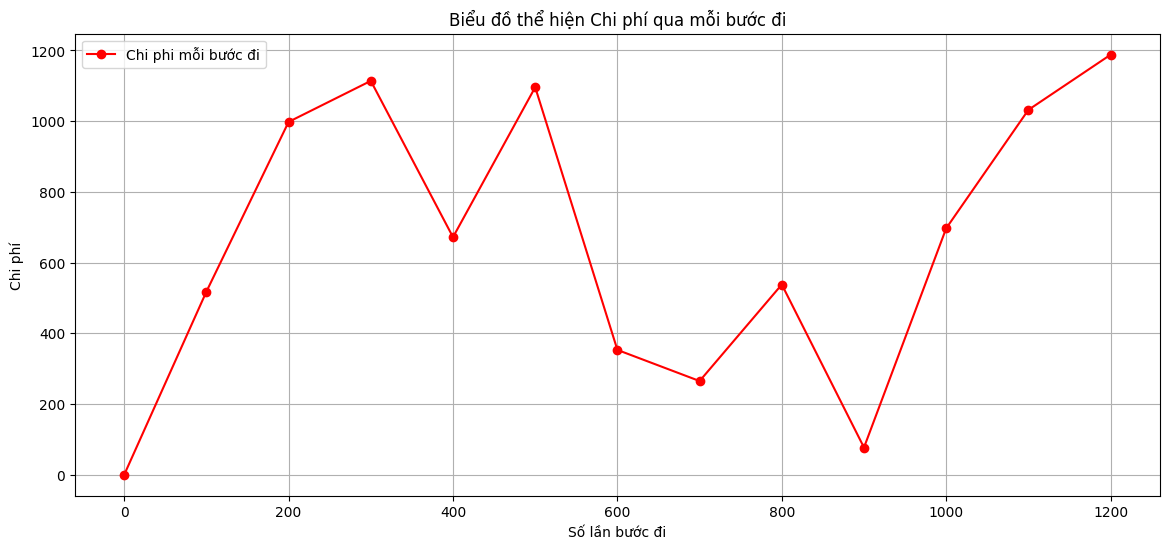

In [97]:
backtrack_counts = [step[0] for step in steps]
total_costs = [step[1] for step in steps]

sample_rate = 100  # Điều chỉnh mật độ
sampled_backtrack_counts = backtrack_counts[::sample_rate]
sampled_total_costs = total_costs[::sample_rate]

plt.figure(figsize=(14, 6))

# Vẽ số lần backtrack
plt.plot(sampled_backtrack_counts, sampled_total_costs, label="Chi phi mỗi bước đi", color='red', marker='o')
plt.title("Biểu đồ thể hiện Chi phí qua mỗi bước đi")
plt.ylabel("Chi phí")
plt.xlabel("Số lần bước đi")
plt.legend()
plt.grid(True)
plt.show()

# **THÍ NGHIỆM BACKTRACKING + MRV**

In [ ]:
class Backtracking_mrv:
    def __init__(self, variables, domains, graph, start, algorithm_choice):
        self.problem = CSPproblem(variables, domains, graph, start, algorithm_choice)
        self.steps = []  # Lưu tổng chi phí tại mỗi bước
        self.backtrack_count = 0  # Số lần thực hiện quay lui

    def backtrack(self, path, current_cost):
        self.steps.append((self.backtrack_count, current_cost))
        self.backtrack_count += 1
        # Kiểm tra trạng thái đã duyệt (memoization)
        memo_key = (tuple(path), current_cost)
        if memo_key in self.problem.memo:
            return
        self.problem.memo[memo_key] = True

        # Nếu tất cả các biến đã được gán, kiểm tra chu trình hoàn chỉnh
        if len(path) == len(self.problem.variables):
            start_city = path[0]
            last_city = path[-1]

            # Thêm chi phí quay về thành phố ban đầu
            for neighbor, cost in self.problem.get_neighbors(last_city):
                if neighbor == start_city:
                    total_cost = current_cost + cost
                    if total_cost < self.problem.min_cost:
                        self.problem.min_cost = total_cost
                        self.problem.min_path = path + [start_city]
                    return

        current_city = self.problem.minimum_remaining_values(path)
        if current_city is not None:
            for neighbor, cost in self.problem.get_neighbors(current_city):
                if self.problem.is_consistent_constraint(neighbor, path):
                    path.append(neighbor)
                    self.backtrack(path, current_cost + cost)
                    path.pop()

    def solve(self, start_city):
        self.problem.min_cost = float('inf')
        self.problem.min_path = []
        self.problem.memo = {}
        self.backtrack([start_city], 0)
        return self.problem.min_path, self.problem.min_cost, self.steps, self.backtrack_count